In [1]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import os
import numpy as np

Using TensorFlow backend.


In [21]:
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [3]:
tf.__version__

'2.0.0'

In [4]:
import pandas as pd

In [5]:
train=pd.read_csv('train.csv.zip')

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
text=train.comment_text

In [8]:
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

### Note: I changed the tokenizer code in keras to tokenize words similar to the way glove tokenized words...for eg can't is tokenized as ca , n't

In [9]:
tokenizer = Tokenizer(num_words=20000)#, oov_token=oov_token)
tokenizer.fit_on_texts(text,)

In [10]:
r2=tokenizer.texts_to_sequences(text)

In [12]:
sequences=r2

In [13]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
median sequence length: 34
max word index: 19999


In [14]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 296846 unique tokens.


In [15]:
data = pad_sequences(sequences, maxlen=100)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [16]:
# print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.twitter.27B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Found 1193514 word vectors.


In [17]:
idx2word={v: k for k, v in word2idx.items()}

In [18]:
num_words = min(20000, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, 100))
for word, i in word2idx.items():
    if i < 20000:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [19]:
embedding_matrix.shape

(20000, 100)

Building model...
Training model...
Train on 143613 samples, validate on 15958 samples
Epoch 1/8
143613/143613 [==============================] - 62s 431us/step - loss: 0.0632 - accuracy: 0.9781 - val_loss: 0.0678 - val_accuracy: 0.9799
Epoch 2/8
143613/143613 [==============================] - 58s 407us/step - loss: 0.0531 - accuracy: 0.9806 - val_loss: 0.0627 - val_accuracy: 0.9808
Epoch 3/8
143613/143613 [==============================] - 60s 416us/step - loss: 0.0506 - accuracy: 0.9813 - val_loss: 0.0578 - val_accuracy: 0.9811
Epoch 4/8
143613/143613 [==============================] - 62s 428us/step - loss: 0.0497 - accuracy: 0.9815 - val_loss: 0.0608 - val_accuracy: 0.9810
Epoch 5/8
143613/143613 [==============================] - 62s 434us/step - loss: 0.0488 - accuracy: 0.9818 - val_loss: 0.0683 - val_accuracy: 0.9801
Epoch 6/8
143613/143613 [==============================] - 62s 433us/step - loss: 0.0486 - accuracy: 0.9819 - val_loss: 0.0624 - val_accuracy: 0.9802
Epoch 7/8
143

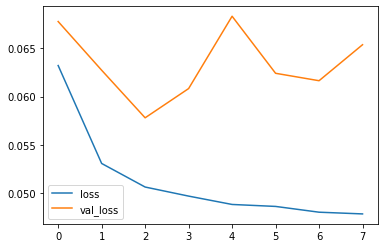

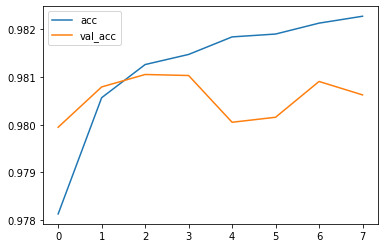

0.9849804045795262


In [22]:
embedding_layer = Embedding(
  20000,
  100,
  weights=[embedding_matrix],
  input_length=100,
  trainable=False
)


print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(100,))
emb = embedding_layer(input_)
conv1 = Conv1D(128, 3, activation='relu')(emb)
drop1= Dropout(0.5)(conv1)
# pool1 = MaxPooling1D(3)(conv1)
# conv2 = Conv1D(128, 3, activation='relu')(pool1)
# pool2 = MaxPooling1D(3)(conv2)
# conv3 = Conv1D(128, 3, activation='relu')(pool2)
pool_max = GlobalMaxPooling1D()(drop1)
dense1 = Dense(64, activation='relu')(pool_max)
drop2= Dropout(0.5)(dense1)
output = Dense(6, activation='sigmoid')(drop2)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=128,
  epochs=8,
  validation_split=0.1
)


# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

In [39]:
test=pd.read_csv('test.csv')

In [40]:
test.columns

Index(['id', 'comment_text'], dtype='object')

In [41]:
test_seq=tokenizer.texts_to_sequences(test.comment_text)

In [43]:
test_padded=pad_sequences(test_seq,maxlen=100)

In [44]:
predictions=model.predict(test_padded)

In [61]:
pred1=pd.DataFrame((predictions),columns=possible_labels)

In [62]:
pred1.set_index(test['id']).reset_index().to_csv('submission1_kaggle_to_prob2.csv',index=False)